## Background

In this notebook, I'll use the code from Jeremy's [Road to the Top, Part 4](https://www.kaggle.com/code/jhoward/multi-target-road-to-the-top-part-4) notebook to train a model that classifies both the disease and the variety of the rice paddy. In the fastai course Part 1 [Lesson 7 video](https://www.youtube.com/watch?v=p4ZZq0736Po&embeds_referring_euri=https%3A%2F%2Fcourse.fast.ai%2F&feature=emb_logo), Jeremy encourages viewers/students to see how this model scores and to explore the inputs and outputs in order to understand how the model behaves. I'll do just that in this notebook. 

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastcore fastai timm

import timm

from fastai.vision.widgets import *
from fastai.vision.all import *

# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uqq fastkaggle

from fastkaggle import *
from fastcore.all import *
from fastdownload import download_url

## Multi-output `DataLoader`

In [2]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
from fastai.vision.all import *
set_seed(42)

from fastcore.parallel import *
trn_path = path/'train_images'

In [6]:
df = pd.read_csv(path/'train.csv', index_col='image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


There are 10 unique `label`s (including `normal`) and 10 unique `variety` values. This means the model will have to predict 10 + 10 = 20 different probabilities.

In [5]:
df['label'].unique().shape, df['variety'].unique().shape

((10,), (10,))

Jeremy creates a `get_variety` helper function which returns the `variety` column value for a given image path. Note that when he created `df`, he passes `index_col='image_id'` in order to make the index of that DataFrame the image path for easier lookup.

In [4]:
def get_variety(p): return df.loc[p.name, 'variety']

In [8]:
get_variety(Path('100330.jpg')) == 'ADT45'

True

Jeremy's `DataBlock` consists of three `blocks`---one `ImageBlock` that processes the inputs and two `CategoryBlock`s, one per target (`label` and `variety`). Because there are three `blocks` we have to specify that the number of inputs, `n_inp` is `1`. Note that we can specify a list of `get_y` getters, one for each target.

In [9]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label,get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

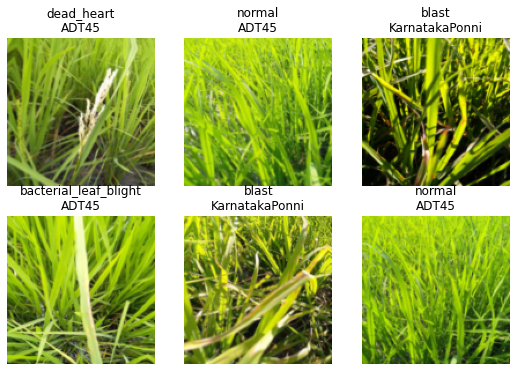

In [10]:
dls.show_batch(max_n=6)

As done in his notebook, I'll first test this approach by training a single-target classifier for disease label. Since there are three `blocks`, the loss function and metrics will receive three things: the predictions (`inp`), the `disease` labels and the `variety` labels.

## Single-target Model with Multi-output `DataLoaders`

In [13]:
error_rate??

Signature: error_rate(inp, targ, axis=-1)
Source:   
def error_rate(inp, targ, axis=-1):
    "1 - `accuracy`"
    return 1 - accuracy(inp, targ, axis=axis)
File:      /opt/conda/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


In [11]:
def disease_err(inp,disease,variety): return error_rate(inp,disease)
def disease_loss(inp,disease,variety): return F.cross_entropy(inp,disease)

In [14]:
learn = vision_learner(dls, resnet34, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()
lr = 0.01

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [15]:
learn.fine_tune(12, lr)

epoch,train_loss,valid_loss,disease_err,time
0,1.950858,1.315877,0.420471,01:15


epoch,train_loss,valid_loss,disease_err,time
0,0.804355,0.466699,0.148967,01:06
1,0.602656,0.520798,0.152811,01:07
2,0.535991,0.533135,0.146084,01:06
3,0.499837,0.413230,0.125420,01:06
4,0.374249,0.522707,0.145123,01:07
5,0.303674,0.249570,0.074003,01:07
6,0.233556,0.222586,0.061989,01:07
7,0.162041,0.166682,0.044690,01:06
8,0.123177,0.137297,0.036521,01:06
9,0.080774,0.139264,0.034599,01:06


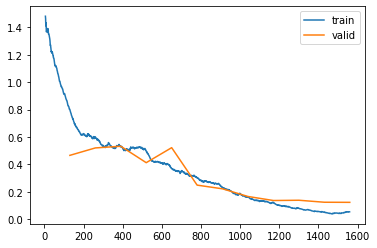

In [16]:
learn.recorder.plot_loss()

The outputs of this model consist of 10 predictions for each image:

In [17]:
probs = learn.tta(dl=learn.dls.valid)

In [23]:
probs[0].shape

torch.Size([2081, 10])

Here's what the activations of the models look like:

In [29]:
probs[0][:5]

tensor([[ 2.8325, -7.3865, -3.3020,  8.6670, -3.5552, -5.3201,  0.5134,  0.8277,
         -1.1257,  1.3131],
        [-0.3330, -4.0044, -4.1958,  0.3577, -2.9964, -3.6226, -0.7052,  3.2369,
          9.9019, -0.7284],
        [-1.3333, -3.0190, -4.2167, -2.3115, -2.1287, -2.2457, -1.8324, -2.1084,
         -1.1698, 13.2637],
        [ 4.0613, 16.8584, -3.1682, -1.8026, -0.4133, -5.2385,  0.7230, -3.3894,
         -7.2209, -2.8204],
        [-1.5410, -0.0458,  1.3879, -0.5194, -2.3740, 13.3403, -1.4106, -4.4908,
         -1.3759, -1.7310]])

Most of the output activations are between -5 and +5:

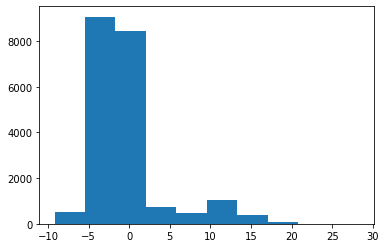

In [32]:
plt.hist(probs[0].flatten().detach().numpy());

The second object returned by `tta` is a tuple where the first tensor is the target `label` for disease and the second tensor is the target `variety`.

In [33]:
probs[0].argmax(dim=1)

tensor([3, 8, 9,  ..., 9, 5, 1])

The error rate for the TTA predictions on the validation set is **0.025**, similar to what Jeremy had.

In [54]:
1 - (probs[0].argmax(dim=1) == probs[1][0]).float().mean()

tensor(0.0250)

I'll now create the test DataLoaders using the test set (making sure to sort the files so they are in the same order as the sample submission CSV):

In [62]:
tst_files = get_image_files(path/'test_images')
tst_files.sort()
tst_files[:5]

(#5) [Path('../input/paddy-disease-classification/test_images/200001.jpg'),Path('../input/paddy-disease-classification/test_images/200002.jpg'),Path('../input/paddy-disease-classification/test_images/200003.jpg'),Path('../input/paddy-disease-classification/test_images/200004.jpg'),Path('../input/paddy-disease-classification/test_images/200005.jpg')]

Then I'll calculate the TTA predictions on the test set:

In [63]:
tst_dl = dls.test_dl(tst_files)
probs = learn.tta(dl=tst_dl)

In [65]:
len(tst_files), probs[0].shape

(3469, torch.Size([3469, 10]))

Most of the activations are between -10 and +10.

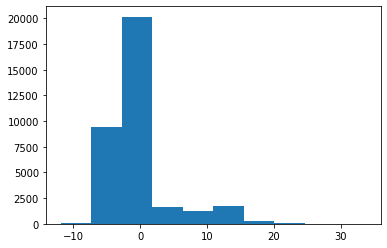

In [67]:
plt.hist(probs[0].flatten().detach().numpy());

Here is the distribution of classes (index of maximum activation per image):

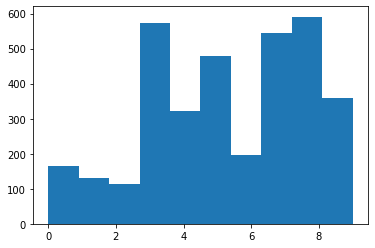

In [68]:
plt.hist(probs[0].argmax(dim=1).flatten().detach().numpy());

I'll export this as a CSV so I can submit it to Kaggle for scoring.

In [69]:
# get the index (class) of the maximum prediction for each item
idxs = probs[0].argmax(dim=1)
idxs

tensor([7, 8, 3,  ..., 8, 1, 5])

The `vocab` contains two sets of labels---one for disease and one for variety. I only want to map the disease labels for now.

In [70]:
dls.vocab[0]

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [71]:
# convert indexes to vocab strings
mapping = dict(enumerate(dls.vocab[0]))
mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [72]:
# add vocab strings to sample submission file and export to CSV
ss = pd.read_csv(path/'sample_submission.csv')
results = pd.Series(idxs.numpy(), name='idxs').map(mapping)
ss.label = results
ss.to_csv('subm1.csv', index=False)

In [73]:
!head subm1.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


This submission resulted in a Private score of **0.97580**.

## Single-target Model with Single-output `DataLoaders`

As another comparison/baseline, I'll train a single-target disease classifier using a single-output `DataLoaders` object.

In [3]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y = parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

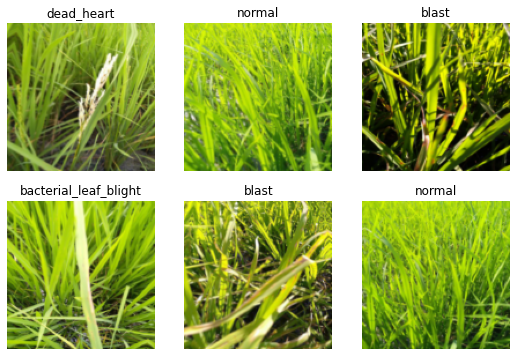

In [4]:
dls.show_batch(max_n=6)

In [5]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(12, 0.01)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.941936,1.325037,0.419990,01:16


epoch,train_loss,valid_loss,error_rate,time
0,0.808069,0.461713,0.158097,01:06
1,0.592128,0.562304,0.172033,01:06
2,0.553166,0.526510,0.142239,01:06
3,0.499870,0.468296,0.137914,01:06
4,0.365323,0.344052,0.095627,00:58
5,0.315392,0.372406,0.105718,00:51
6,0.245668,0.210443,0.062470,00:51
7,0.165351,0.178430,0.047093,00:51
8,0.112827,0.153295,0.038924,00:50
9,0.079190,0.144607,0.033638,00:51


In [6]:
probs = learn.tta(dl=learn.dls.valid)

In [10]:
probs[0].shape, probs[1].shape

(torch.Size([2081, 10]), torch.Size([2081]))

This model has a slightly better TTA error rate on the validation set.

In [11]:
1 - (probs[0].argmax(dim=1) == probs[1]).float().mean()

tensor(0.0240)

There is only one set of `vocab` since there is only 1 target:

In [12]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [13]:
tst_files = get_image_files(path/'test_images')
tst_files.sort()

tst_dl = dls.test_dl(tst_files)
probs = learn.tta(dl=tst_dl)

# get the index (class) of the maximum prediction for each item
idxs = probs[0].argmax(dim=1)

# convert indexes to vocab strings
mapping = dict(enumerate(dls.vocab))

# add vocab strings to sample submission file and export to CSV
ss = pd.read_csv(path/'sample_submission.csv')
results = pd.Series(idxs.numpy(), name='idxs').map(mapping)
ss.label = results
ss.to_csv('subm2.csv', index=False)
!head subm2.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


This submission got the same Private score as the single-target model trained on the multi-output DataLoaders: **0.97580**

## Multi-target model on Multi-output `DataLoaders`

In [7]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label,get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

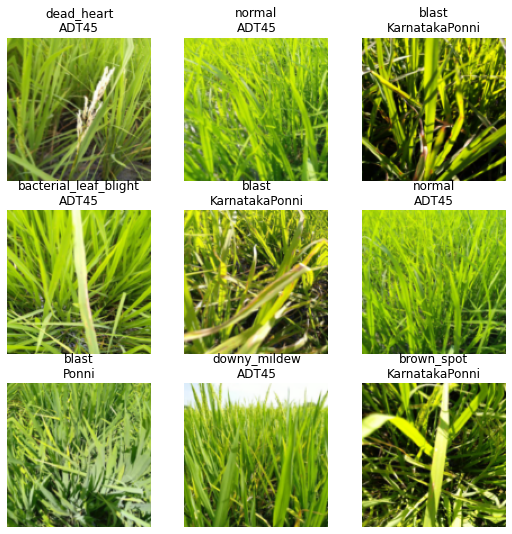

In [8]:
dls.show_batch()

Jeremy picks the first ten activations of the model as the disease classes and the second ten as the variety classes. The `disease_loss` and `variety_loss` are defined accordingly:

In [9]:
def disease_loss(inp,disease,variety): return F.cross_entropy(inp[:,:10],disease)

In [10]:
def variety_loss(inp,disease,variety): return F.cross_entropy(inp[:,10:],variety)

The combined loss we are trying to minimize is the sum of the two target's loss:

In [11]:
def combine_loss(inp,disease,variety): return disease_loss(inp,disease,variety)+variety_loss(inp,disease,variety)

The error rates are defined the same way (first 10 predictions for disease, second 10 for variety):

In [12]:
def disease_err(inp,disease,variety): return error_rate(inp[:,:10],disease)
def variety_err(inp,disease,variety): return error_rate(inp[:,10:],variety)

err_metrics = (disease_err,variety_err)

Jeremy also chooses to view the disease loss and variety loss separately.

In [13]:
all_metrics = err_metrics+(disease_loss,variety_loss)

`n_out` is set to `20` since we have two pairs of 10 classes that the model is trying to predict.

In [14]:
learn = vision_learner(dls, resnet34, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Jeremy mentioned that we might have to train this model for longer before it performs as well as the single-target model since we are asking to do more (predicts twice the number of targets). I'll train and submit with 12 epochs first as a baseline.

In [15]:
learn.fine_tune(12, 0.01)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.191633,1.969826,0.419990,0.219125,1.272959,0.696868,01:19


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.266333,0.694686,0.154733,0.059106,0.489899,0.204788,01:06
1,0.887806,0.605122,0.146564,0.053340,0.440036,0.165086,01:06
2,0.834215,1.014124,0.188371,0.090341,0.617206,0.396918,01:06
3,0.709637,0.634970,0.117732,0.058145,0.439491,0.195479,01:06
4,0.587873,0.580158,0.120135,0.045651,0.420883,0.159275,01:06
5,0.453230,0.404975,0.084575,0.031716,0.295974,0.109001,01:06
6,0.332355,0.315852,0.069678,0.017780,0.252630,0.063222,01:07
7,0.240017,0.276671,0.054781,0.025469,0.197499,0.079172,01:07
8,0.166121,0.182990,0.039885,0.012494,0.140265,0.042726,01:06
9,0.112039,0.182566,0.036040,0.011533,0.138646,0.043920,01:06


In [16]:
probs = learn.tta(dl=learn.dls.valid)

There are 20 predictions for each image.

In [17]:
probs[0].shape

torch.Size([2081, 20])

The first 10 predictions are for the disease `label`.

In [23]:
1 - (probs[0][:,:10].argmax(dim=1) == probs[1][0]).float().mean()

tensor(0.0279)

The TTA error rate on the validation set is slightly lower than the single-target models.

Just out of curiosity, I'll also calculate the TTA error rate for `variety`:

In [24]:
1 - (probs[0][:,10:].argmax(dim=1) == probs[1][1]).float().mean()

tensor(0.0077)

The model is much more accurate at predicting the `variety` of rice.

I'll submit TTA predictions on the test set:

In [25]:
tst_files = get_image_files(path/'test_images')
tst_files.sort()

tst_dl = dls.test_dl(tst_files)
probs = learn.tta(dl=tst_dl)

# get the index (class) of the maximum prediction for each item
idxs = probs[0][:,:10].argmax(dim=1)

# convert indexes to vocab strings
mapping = dict(enumerate(dls.vocab[0]))

# add vocab strings to sample submission file and export to CSV
ss = pd.read_csv(path/'sample_submission.csv')
results = pd.Series(idxs.numpy(), name='idxs').map(mapping)
ss.label = results
ss.to_csv('subm3.csv', index=False)
!head subm3.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


This model gave me the same Private score: **0.97580**.

Finally, I'll train the model for a few more epochs and see if that improves the score.

In [26]:
learn = vision_learner(dls, resnet34, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()
learn.fine_tune(16, 0.01)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.186875,2.025326,0.409419,0.214320,1.350042,0.675284,01:06


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.275486,0.722841,0.168188,0.068236,0.495478,0.227363,01:06
1,0.812811,0.582493,0.128784,0.053340,0.401935,0.180558,01:08
2,0.736832,0.655212,0.145603,0.064873,0.447887,0.207325,01:08
3,0.777283,1.089296,0.193176,0.119654,0.611161,0.478135,01:08
4,0.656918,0.736651,0.132148,0.063912,0.465955,0.270696,01:07
5,0.611457,0.523899,0.104277,0.044690,0.359421,0.164478,01:06
6,0.497228,0.408523,0.076886,0.039885,0.276221,0.132302,01:11
7,0.418236,0.349095,0.065834,0.026430,0.262863,0.086232,01:10
8,0.292306,0.334778,0.070639,0.022105,0.253223,0.081556,01:07
9,0.223652,0.276235,0.051418,0.014897,0.214205,0.062030,01:06


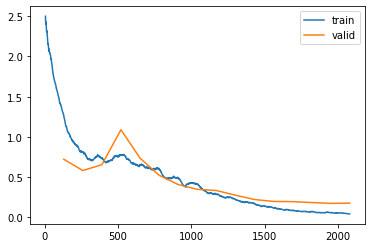

In [27]:
learn.recorder.plot_loss()

In [28]:
probs = learn.tta(dl=learn.dls.valid)
1 - (probs[0][:,:10].argmax(dim=1) == probs[1][0]).float().mean()

tensor(0.0245)

That's a slightly better TTA validation error rate.

In [29]:
tst_files = get_image_files(path/'test_images')
tst_files.sort()

tst_dl = dls.test_dl(tst_files)
probs = learn.tta(dl=tst_dl)

# get the index (class) of the maximum prediction for each item
idxs = probs[0][:,:10].argmax(dim=1)

# convert indexes to vocab strings
mapping = dict(enumerate(dls.vocab[0]))

# add vocab strings to sample submission file and export to CSV
ss = pd.read_csv(path/'sample_submission.csv')
results = pd.Series(idxs.numpy(), name='idxs').map(mapping)
ss.label = results
ss.to_csv('subm4.csv', index=False)
!head subm4.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


The Private scored improved to **0.97811**! That's not insignificant. Training on multi-target, at least for a resnet34 on the `Resize(192, method='squish')` item transform and `aug_transforms(size=128, min_scale=0.75)` batch transform. Here is the summary of the four submissions from this notebook:

![](1.png)

## Final Thoughts

I am so glad that I ran this experiment since I am currently involved in a Kaggle competition where I was considering multi-target classification. There's no certainty that it'll improve my Private score in that situation, but it's promising to see it improve the Paddy Disease Classification Private score here. Many thanks to Jeremy for introducing us to these engaging concepts.

I hope you enjoyed this blog post!